<a href="https://colab.research.google.com/github/jeong1suk/SmartRefrigerator/blob/main/GPT_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture
!sudo apt-get install -y fonts-nanum
!sudo fc-cache -fv
!rm ~/.cache/matplotlib -rf
import matplotlib.pyplot as plt
plt.rc('font', family='NanumBarunGothic')

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
%%capture
!pip install gdown
!pip install einops
!pip install 'git+https://github.com/SKTBrain/KoBERT.git#egg=kobert_tokenizer&subdirectory=kobert_hf'

In [4]:
import torch
from torch import nn, optim
from torch.optim.lr_scheduler import LambdaLR
from kobert_tokenizer import  KoBERTTokenizer
import pandas as pd
from tqdm import tqdm
import math, random
from einops import rearrange
import time

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print(DEVICE)

cpu


In [5]:
# for random seed
random_seed = 0
torch.manual_seed(random_seed)
torch.cuda.manual_seed(random_seed)
torch.cuda.manual_seed_all(random_seed) # if use multi-GPU
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
random.seed(random_seed)

In [6]:
tokenizer = KoBERTTokenizer.from_pretrained('skt/kobert-base-v1')
pad_idx = tokenizer.pad_token_id
print("pad_idx = ", pad_idx)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/432 [00:00<?, ?B/s]

spiece.model:   0%|          | 0.00/371k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/244 [00:00<?, ?B/s]

The tokenizer class you load from this checkpoint is not the same type as the class this function is called from. It may result in unexpected tokenization. 
The tokenizer class you load from this checkpoint is 'XLNetTokenizer'. 
The class this function is called from is 'KoBERTTokenizer'.


pad_idx =  1


## 하이퍼파라미터 조정

In [8]:
vocab_size = tokenizer.vocab_size
print(vocab_size)

n_layers = 12
d_model = 768
d_ff = d_model * 4
n_heads = 12
drop_p = 0.25

8002


## DS, DL 생성 & 테스트

In [11]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return self.data.shape[0]

    def __getitem__(self, idx):
        return self.data.loc[idx, '원문']

custom_DS = CustomDataset(data)

train_DS, val_DS, test_DS, _ = torch.utils.data.random_split(custom_DS, [97000, 2000, 1000, len(custom_DS)-97000-2000-1000])

train_DL = torch.utils.data.DataLoader(train_DS, batch_size=BATCH_SIZE, shuffle=True)
val_DL = torch.utils.data.DataLoader(val_DS, batch_size=BATCH_SIZE, shuffle=True)
test_DL = torch.utils.data.DataLoader(test_DS, batch_size=BATCH_SIZE, shuffle=True)

print(len(train_DS))
print(len(val_DS))
print(len(test_DS))

97000
2000
1000


## 모델 구현

In [13]:
class MHA(nn.Module):
    def __init__(self, d_model, n_heads, drop_p):
        super().__init__()

        self.n_heads = n_heads

        self.fc_q = nn.Linear(d_model, d_model)
        self.fc_k = nn.Linear(d_model, d_model)
        self.fc_v = nn.Linear(d_model, d_model)
        self.fc_o = nn.Linear(d_model, d_model)

        self.dropout = nn.Dropout(drop_p)
        self.scale = torch.sqrt(torch.tensor(d_model / n_heads))

    def forward(self, x, mask=None):
        Q = self.fc_q(x)
        K = self.fc_k(x)
        V = self.fc_v(x)

        Q = rearrange(Q, '배치 헤드 (시퀀스 차원) -> 배치 헤드 시퀀스 차원', 헤드=self.n_heads)
        K = rearrange(K, '배치 헤드 (시퀀스 차원) -> 배치 헤드 시퀀스 차원', 헤드=self.n_heads)
        V = rearrange(V, '배치 헤드 (시퀀스 차원) -> 배치 헤드 시퀀스 차원', 헤드=self.n_heads)


        attention_score = Q @ K.transpose(-2,-1) / self.scale

        if mask is not None:
            attention_score[mask] = -1e10
        attention_weights = torch.softmax(attention_score, dim=-1)

        attention_weights = self.dropout(attention_weights)

        attention = attention_weights @ V

        x = rearrange(attention, '배치 헤드 시퀀스 차원 -> 배치 시퀀스 (헤드 차원)')
        x = self.fc_o(x)

        return x, attention_weights

class FeedForward(nn.Module):
    def __init__(self, d_model, d_ff, drop_p):
        super().__init__()

        self.linear = nn.Sequential(nn.Linear(d_model, d_ff),
                                    nn.GELU(),
                                    nn.Dropout(drop_p)
                                    nn.Linear(d_ff, d_model))

    def forward(self, x):
        x = self.linear(x)
        return x

class DecoderLayer(nn.Module):
    def __init__(self, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.self_atten_LN = nn.LayerNorm(d_model)
        self.self_atten = MHA(d_model, n_heads, drop_p)

        self.FF_LN = nn.LayerNorm(d_model)
        self.FF = FeedForward(d_model, d_ff, drop_p)

        self.dropout = nn.Dropout(drop_p)

    def forward(self, x, dec_mask):

        residual = self.self_atten_LN(x)
        residual, atten_dec = self.self_atten(residual, dec_mask)
        residual = self.dropout(residual) # norm -> attn -> drop -> add
        x = x + residual

        residual = self.FF_LN(x)
        residual = self.FF(residual)
        residual = self.dropout(residual)
        x = x + residual

        return x, atten_dec

class Decoder(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.input_embedding = nn.Embedding(vocab_size, d_model)
        self.pos_embedding = nn.Embedding(max_len, d_model)

        self.dropout = nn.Dropout(drop_p)

        self.layers = nn.ModuleList([DecoderLayer(d_model, d_ff, n_heads, drop_p) for _ in range(n_layers)])

        self.LN_out = nn.LayerNorm(d_model)
        self.fc_out = nn.Linear(d_model, vocab_size)

    def forward(self, x, dec_mask, atten_map_save = False):

        pos = torch.arange(x.shape[1]).expand_as(x).to(DEVICE)

        x = self.input_embedding(x) + self.pos_embedding(pos)
        x = self.dropout(x)

        atten_decs = torch.tensor([]).to(DEVICE)
        for layer in self.layers:
            x, atten_dec = layer(x, dec_mask)
            if atten_map_save is True:
                atten_decs = torch.cat([atten_decs , atten_dec[0].unsqueeze(0)], dim=0)

        x = self.LN_out(x)
        x = self.fc_out(x)

        return x, atten_decs

class GPT(nn.Module):
    def __init__(self, vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p):
        super().__init__()

        self.decoder = Decoder(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p)

        self.n_heads = n_heads

        # 초기화 기법은 GPT-2 참고해서 만듦
        for m in self.modules():
            if isinstance(m, nn.Linear):
                nn.init.normal_(m.weight, mean=0, std=0.02)
                m.weight.data *= 1/torch.sqrt(torch.tensor(n_layers*2))
            elif isinstance(m, nn.Embedding):
                nn.init.normal_(m.weight, mean=0, std=0.02)

        nn.init.normal_(self.decoder.fc_out.weight, mean=0, std=0.02)

    def make_dec_mask(self, x):

        pad_mask = (x == pad_idx).unsqueeze(1).unsqueeze(2)
        pad_mask = pad_mask.expand(x.shape[0], self.n_heads, x.shape[1], x.shape[1])
        """ pad mask
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        F F F T T
        """
        future_mask = torch.tril(torch.ones(x.shape[0], self.n_heads, x.shape[1], x.shape[1]))==0
        future_mask = future_mask.to(DEVICE)
        """ future mask
        F T T T T
        F F T T T
        F F F T T
        F F F F T
        F F F F F
        """
        dec_mask = pad_mask | future_mask # dec_mask.shape
        """ decoder mask
        F T T T T
        F F T T T
        F F F T T
        F F F T T
        F F F T T
        """
        return dec_mask

    def forward(self, x, atten_map_save = False):

        dec_mask = self.make_dec_mask(x)
        out, atten_decs = self.decoder(x, dec_mask, atten_map_save = atten_map_save)

        return out, atten_decs

In [14]:
Q = torch.randn(1, 4, 6)
print(Q)

Q = rearrange(Q, '배치 시퀀스 (헤드 차원) -> 배치 헤드 시퀀스 차원', 헤드 = 3)

print(Q)
print(Q.shape)

x = rearrange(Q, '배치 헤드 시퀀스 차원 -> 배치 시퀀스 (헤드 차원)')
print(x)
print(x.shape)

tensor([[[ 0.2595, -0.4927, -0.4737, -0.2074, -1.9427, -1.7322],
         [-0.5939, -1.1785, -0.7656, -1.9260, -0.8876, -0.6519],
         [ 0.1413, -1.7858,  0.2259, -0.0683, -0.4737, -1.9399],
         [-1.4287, -0.6150,  0.4548,  0.8434,  1.2168, -0.7239]]])
tensor([[[[ 0.2595, -0.4927],
          [-0.5939, -1.1785],
          [ 0.1413, -1.7858],
          [-1.4287, -0.6150]],

         [[-0.4737, -0.2074],
          [-0.7656, -1.9260],
          [ 0.2259, -0.0683],
          [ 0.4548,  0.8434]],

         [[-1.9427, -1.7322],
          [-0.8876, -0.6519],
          [-0.4737, -1.9399],
          [ 1.2168, -0.7239]]]])
torch.Size([1, 3, 4, 2])
tensor([[[ 0.2595, -0.4927, -0.4737, -0.2074, -1.9427, -1.7322],
         [-0.5939, -1.1785, -0.7656, -1.9260, -0.8876, -0.6519],
         [ 0.1413, -1.7858,  0.2259, -0.0683, -0.4737, -1.9399],
         [-1.4287, -0.6150,  0.4548,  0.8434,  1.2168, -0.7239]]])
torch.Size([1, 4, 6])


## 모델 생성

In [15]:
model = GPT(vocab_size, max_len, n_layers, d_model, d_ff, n_heads, drop_p).to(DEVICE)

x = torch.tensor([[2,5,4,4,3,1,1],[2,9,6,7,3,1,1]]).to(DEVICE)
print(x.shape)

model.eval()
with torch.no_grad():
    x = model(x)[0]
print(x.shape)

torch.Size([2, 7])
torch.Size([2, 7, 8002])


## Train, Test, loss_epoch 함수

In [16]:
def Train(model, train_DL, val_DL, criterion, optimizer, scheduler = None):
    loss_history = {"train": [], "val": []}
    best_loss = 9999
    for ep in range(EPOCH):
        epoch_start = time.time()

        model.train() # train mode로 전환
        train_loss = loss_epoch(model, train_DL, criterion, optimizer = optimizer, scheduler = scheduler)
        loss_history["train"] += [train_loss]

        model.eval() # test mode로 전환
        with torch.no_grad():
            val_loss = loss_epoch(model, val_DL, criterion)
            loss_history["val"] += [val_loss]
            if val_loss < best_loss:
                best_loss = val_loss
                torch.save({"model": model,
                            "ep": ep,
                            "optimizer": optimizer,
                            "scheduler": scheduler,}, save_model_path)
        # print loss
        print(f"Epoch {ep+1}: train loss: {train_loss:.5f}   val loss: {val_loss:.5f}   current_LR: {optimizer.param_groups[0]['lr']:.8f}   time: {time.time()-epoch_start:.0f} s")
        print("-" * 20)

    torch.save({"loss_history": loss_history,
                "EPOCH": EPOCH,
                "BATCH_SIZE": BATCH_SIZE}, save_history_path)

def Test(model, test_DL, criterion):
    model.eval() # test mode로 전환
    with torch.no_grad():
        test_loss = loss_epoch(model, test_DL, criterion)
    print(f"Test loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):.3f}")

def loss_epoch(model, DL, criterion, optimizer = None, scheduler = None):
    N = len(DL.dataset) # the number of data

    rloss=0
    for texts in tqdm(DL, leave=False):
        texts = [s + ' [SEP]'for s in texts]
        x_batch = tokenizer(texts, padding=True, truncation=True, max_length = max_len, return_tensors='pt', add_special_tokens = False).input_ids.to(DEVICE)
        # inference
        y_hat = model(x_batch[:,:-1])[0]

        # loss
        loss = criterion(y_hat.permute(0,2,1), x_batch[:,1:])
        # update
        if optimizer is not None:
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
        if scheduler is not None:
            scheduler.step()
        # loss accumulation
        loss_b = loss.item() * x_batch.shape[0]
        rloss += loss_b
    loss_e = rloss/N
    return loss_e

def count_params(model):
    num = sum([p.numel() for p in model.parameters() if p.requires_grad])
    return num

def plot_scheduler(optimizer, scheduler, total_steps): # LR curve 보기
    lr_history = []
    steps = range(1, total_steps)

    for _ in steps:
        lr_history += [optimizer.param_groups[0]['lr']]
        scheduler.step()

    plt.figure()
    plt.plot(steps, lr_history, 'b', linewidth=2, label="Learning Rate")
    plt.ylim([-0.1*max(lr_history), 1.2*max(lr_history)])
    plt.xlabel('Step')
    plt.ylabel('Learning Rate')
    plt.grid()
    plt.legend()
    plt.show()

/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:224: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


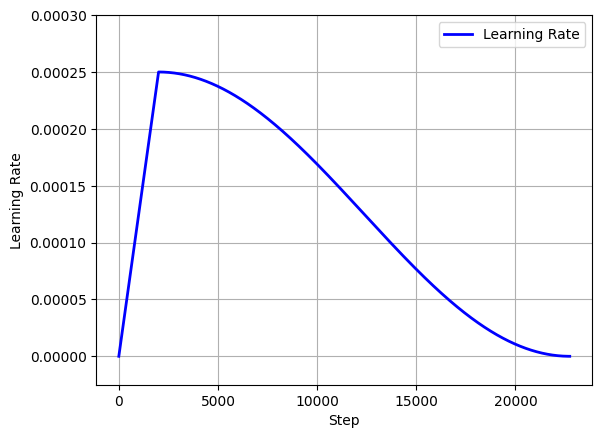

In [17]:
optimizer = optim.AdamW(nn.Linear(1, 1).parameters(), lr=LR_peak)
scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)
plot_scheduler(optimizer = optimizer, scheduler = scheduler, total_steps = total_steps)

## 모델 학습

In [18]:
if new_model_train:
    params = [p for p in model.parameters() if p.requires_grad] # 사전 학습된 layer를 사용할 경우를 대비
    optimizer = optim.AdamW(params, lr=LR_peak, weight_decay=LAMBDA) # GPT-1 논문에서 AdamW를 사용했음
    scheduler = LambdaLR(optimizer, lr_lambda=lr_lambda)

    Train(model, train_DL, val_DL, criterion, optimizer, scheduler)

## 로드 모델

In [19]:
loaded = torch.load(save_model_path, map_location=DEVICE)
load_model = loaded["model"]
ep = loaded["ep"]
optimizer = loaded["optimizer"]

loaded = torch.load(save_history_path, map_location=DEVICE)
loss_history = loaded["loss_history"]

print(ep)
print(optimizer)

<ipython-input-19-c96f6b8a1623>:1: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(save_model_path, map_location=DEVICE)


12
AdamW (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    initial_lr: 0.00025
    lr: 1.2953088643299582e-05
    maximize: False
    weight_decay: 0
)


<ipython-input-19-c96f6b8a1623>:6: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  loaded = torch.load(save_history_path, map_location=DEVICE)


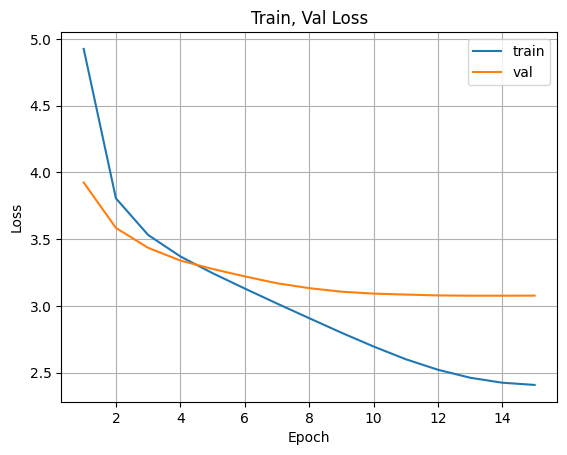

In [20]:
plt.figure()
plt.plot(range(1,EPOCH+1),loss_history["train"], label="train")
plt.plot(range(1,EPOCH+1),loss_history["val"], label="val")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train, Val Loss")
plt.grid()
plt.legend()

In [21]:
Test(load_model, test_DL, criterion)
count_params(load_model)

Test loss: 3.090 | Test PPL: 21.978


97431874

## Next Token Prediction 함수, 어텐션 map 그리는 함수

In [22]:
def generate(model, src_text, atten_map_save = False):
    model.eval()
    with torch.no_grad():
        pred = tokenizer.encode(src_text, return_tensors='pt', add_special_tokens=False).to(DEVICE) # 1x단
        init_length = pred.shape[1]

        for _ in range(max_len-init_length):
            out, atten_decs = model(pred, atten_map_save = atten_map_save)
            # out.shape = (개=1,단,차)

            pred_word = out[:,-1,:].argmax(dim=1).unsqueeze(0) # 마지막 단어에 대해 argmax해서 prediction 하고 shape = (1,1)로
            pred = torch.cat([pred, pred_word], dim=1) # 1x단 (단은 하나씩 늘면서)

            if tokenizer.decode(pred_word.item()) == '[SEP]':
                break

        pred_text = tokenizer.decode(pred[0])

    return pred_text, atten_decs

In [25]:
# 생성해보기
# src_text = "오이와 당근으로 만들수 있는 음식은"
# src_text = "오이와 당근으로 만들 수 있는 음식의 레시피"
src_text = "오이와 당근으로 만들 수 있는 요리법"
print(f"입력: {src_text}")

pred_text, atten_decs = generate(load_model, src_text, atten_map_save = True)
print(f"생성된 문장: {pred_text}")

입력: 오이와 당근으로 만들 수 있는 요리법
생성된 문장: 오이와 당근으로 만들 수 있는 요리법이 있나요?[SEP]
